<a href="https://colab.research.google.com/github/ElpoderdelComputo/SEI-Computo_aplicado/blob/main/Sel_caracteristicas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COLEGIO DE POSTGRADUADOS**

INSTITUCIÓN DE ENSEÑANZA E INVESTIGACIÓN EN CIENCIAS AGRÍCOLAS

CAMPUS MONTECILLO

POSGRADO EN SOCIOECONOMÍA, ESTADÍSTICA E INFORMÁTICA

**CÓMPUTO APLICADO**



```
# Selección e Importancia de las características
```

Autor: José Rodríguez Rosales


In [4]:
# Importar librerías
import pandas as pd
import numpy as np

# Leer datos desde disco
df = pd.read_csv('/content/drive/MyDrive/Datos_2002_2021/Train_2021.csv',header=0)

# columnas que se van a utilizar de la matriz
df.columns = ['X', 'Y', 'R', 'G','B', 'ExG', 'ExR','ExGR', 'CIVE', 'VEG', 'NGRDI','NDI','Clase']

print('Class labels', np.unique(df['Clase']))
df.head()


Class labels [1 2 3 4]


,X,Y,R,G,B,ExG,ExR,ExGR,CIVE,VEG,NGRDI,NDI,Clase
0,26,89,62,76,76,14,10.8,3.2,28.95345,1.145453,0.101449,140.985507,4
1,24,88,66,80,81,13,12.4,0.6,30.39845,1.132214,0.095890,140.273973,4
2,26,87,67,81,81,14,12.8,1.2,30.02845,1.134926,0.094595,140.108108,4
3,27,87,67,82,79,18,11.8,6.2,28.04745,1.158543,0.100671,140.885906,4
4,80,61,70,71,73,-1,27.0,-28.0,34.78145,1.000211,0.007092,128.907801,4


In [5]:
# Dividir conjunto de datos 90 % entrenamiento y 10 % para validacion
# Semilla random_state = 1
from sklearn.model_selection import train_test_split

X, y = df.iloc[:, 2:12].values, df.iloc[:, 12].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.1, 
                     random_state=1, 
                     stratify=y)

# Estandarizar los datos
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)


In [23]:
# Algoritmos de selección de características secuenciales selección secuencial hacia atrás (SBS)
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Crear clase SBS
class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.1, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
      # Ajuste de los datos  
      X_train, X_test, y_train, y_test = \
          train_test_split(X, y, test_size=self.test_size,
                           random_state=self.random_state)
      
                         
      dim = X_train.shape[1]
      self.indices_ = tuple(range(dim))
      self.subsets_ = [self.indices_]
      score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
      self.scores_ = [score]

      # Calcular score de las caracteristicas
      while dim > self.k_features:
          scores = []
          subsets = []

          for p in combinations(self.indices_, r=dim - 1):
              score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
              scores.append(score)
              subsets.append(p)

          best = np.argmax(scores)
          self.indices_ = subsets[best]
          self.subsets_.append(self.indices_)
          dim -= 1

          self.scores_.append(scores[best])
      self.k_score_ = self.scores_[-1]

      return self

    def transform(self, X):
        return X[:, self.indices_]

    # Predecir y calcular indices
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score


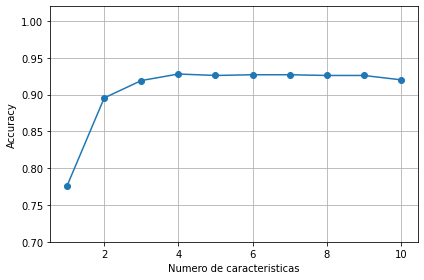

In [24]:
# Trazar numero de características contra precisión global
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=100,
                       n_jobs=-1, random_state=1)

# Seleccionar características
sbs = SBS(RF, k_features=1)
sbs.fit(X, y)

# representación gráfica del rendimiento de los subconjuntos de características
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Numero de caracteristicas')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()


In [25]:
# Mostrar las primeras 4 características
k6 = list(sbs.subsets_[5])
print(df.columns[1:][k6])


Index(['Y', 'R', 'G', 'ExGR', 'VEG'], dtype='object')


In [26]:
# Evaluamos el rendimiento del clasificador RF en el conjunto de prueba original
RF.fit(X_train_std, y_train)
print('Training accuracy:', RF.score(X_train_std, y_train))
print('Test accuracy:', RF.score(X_test_std, y_test))

Training accuracy: 0.9549737072743207
Test accuracy: 0.9270935960591133


In [27]:
#Usamos el subconjunto de tres características seleccionado y veamos qué tan bien se desempeña RF:
RF.fit(X_train_std[:, k6], y_train)
print('Training accuracy:', RF.score(X_train_std[:, k6], y_train))
print('Test accuracy:', RF.score(X_test_std[:, k6], y_test))

Training accuracy: 0.9544259421560035
Test accuracy: 0.9241379310344827


 1) R                              0.186060
 2) G                              0.138528
 3) ExR                            0.112211
 4) NGRDI                          0.106960
 5) NDI                            0.100584
 6) B                              0.096341
 7) ExGR                           0.087903
 8) VEG                            0.086378
 9) CIVE                           0.054559
10) ExG                            0.030477


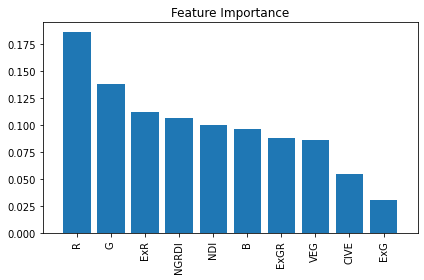

In [31]:
# Evaluación de la importancia de las características con Random Forests
from sklearn.ensemble import RandomForestClassifier

feat_labels = df.columns[2:]
# Creamos un modelo RF
forest = RandomForestClassifier(criterion='gini', max_depth=10, max_features = "log2", n_estimators=300,
                       n_jobs=-1, random_state=1)
                       
forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()


In [29]:
# Establecemos un umbral: .07
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.07, prefit=True)
X_selected = sfm.transform(X_train)
print('Número de entidades que cumplen este criterio de umbral:', 
      X_selected.shape[1])


Número de entidades que cumplen este criterio de umbral: 8


In [30]:
# Mostrar las mejores características de acuerdo al umbral
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))


 1) R                              0.186060
 2) G                              0.138528
 3) ExR                            0.112211
 4) NGRDI                          0.106960
 5) NDI                            0.100584
 6) B                              0.096341
 7) ExGR                           0.087903
 8) VEG                            0.086378
